In [33]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u
import nana
from scipy.interpolate import CubicSpline
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
from math import cos, sin, radians
from matplotlib.collections import EllipseCollection

In [2]:
def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)


def folding_freq(fs, ps, sampling_time, makeplots=False):
    """
    ##bugs:
    - assumes fs are ordered
    - global delta_f
    """
    fc_guess = 1. / sampling_time
    
    IA = fs < 0.5 * fc_guess
    fsA, psA = fs[IA], ps[IA]
    fsA,psA  = fsA[2:-2],  psA[2:-2]
    cs = CubicSpline(fs, ps, extrapolate=False)
    
    small, tiny = 20 * delta_f, 0.25 * delta_f
    fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny)
    foos_c = np.array([np.nansum(psA * cs(fc - fsA)) for fc in fc_candidates])
    fc_index = get_started(1,fc_candidates, foos_c)
    fc, _, _ = refine_peaks(fc_candidates, foos_c, fc_index)
    fc = fc[0]
    
    if makeplots:
        plt.plot(fc_candidates, foos_c)
        plt.axvline(fc_guess)
        plt.axvline(fc, color = 'red', alpha = 0.5)
        plt.title(fc)
        plt.show()

    
    return fc


In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) 
sampling_time= np.median(np.diff(lc.time.value))

In [5]:
f_max = (2 / (sampling_time))
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

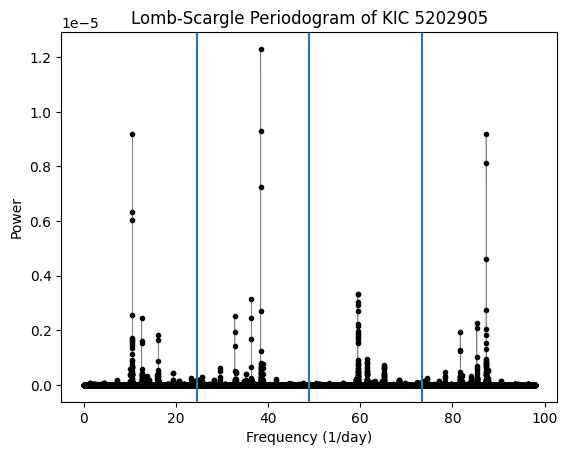

In [6]:
pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

plt.plot(freq, power,'k.')
plt.plot(freq, power,'k-', lw = 0.5, alpha = 0.5)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.axvline(1/sampling_time)
plt.axvline(1/(2*sampling_time))
plt.axvline(3/(2*sampling_time))
plt.show() 

In [7]:
indices = get_started(10, freq, power)
refined_freq, _ , _ = refine_peaks(freq, power, indices)
nu = refined_freq[0]

In [8]:
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value

In [9]:
t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean)

lc = lc[mask]
t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]

In [10]:
lc_exptime = (6.52 * 270) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1
weight_fit = 1 / sigma_fit**2

def integral_design_matrix(ts, om, T):
    """
    ##bugs:
    - assumes all data points have the same exposure time, `T`
    - not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (+ np.sin(om * (ts + T/2)) - np.sin(om * (ts - T/2))) / (om * T),
        (- np.cos(om * (ts + T/2)) + np.cos(om * (ts - T/2))) / (om * T)
    ]).T

def weighted_least_squares(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return np.linalg.solve(ATA, ATb), ATA

def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

In [11]:
def check_coherence(ts, ys, weights, om):
    """
    assumes a lot of things about the data
    """
    cases = [(np.ones_like(ts).astype(bool), "all"),
             (ts < np.median(ts), "early"),
             (ts > np.median(ts), "late")]
    for I, name in cases:
        A = integral_design_matrix(ts[I], om, lc_exptime)
        pars, invar = weighted_least_squares(A, ys[I], weights[I])
        print(name, pars, invar)

In [12]:
check_coherence(t_fit, flux_fit, weight_fit, 2. * np.pi * nu)

all [ 9.99998638e-01 -6.78285816e-04 -1.57832037e-03] [[ 9.68972845e+12  7.24363153e+07 -4.91672081e+08]
 [ 7.24363153e+07  3.19901088e+11  7.86859697e+07]
 [-4.91672081e+08  7.86859697e+07  3.20159951e+11]]
early [ 9.99997834e-01 -5.84807771e-04 -1.35645998e-03] [[4.83662679e+12 6.17480784e+06 5.14053501e+07]
 [6.17480784e+06 1.59684706e+11 1.22300327e+08]
 [5.14053501e+07 1.22300327e+08 1.59801684e+11]]
late [ 9.99999410e-01 -7.71711971e-04 -1.79950855e-03] [[ 4.85291385e+12  1.84629204e+07 -5.49793341e+08]
 [ 1.84629204e+07  1.60204217e+11 -4.53236434e+07]
 [-5.49793341e+08 -4.53236434e+07  1.60358026e+11]]


In [28]:
def check_coherence(ts, ys, weights, om):
    """
    assumes a lot of things about the data
    """
    axes, As,Bs = [],[], []
    cases = [(np.ones_like(ts).astype(bool), "all"),
             (ts < np.median(ts), "early"),
             (ts > np.median(ts), "late")]
    for I, name in cases:
        A = integral_design_matrix(ts[I], om, lc_exptime)
        pars, invar = weighted_least_squares(A, ys[I], weights[I])
        a,b = pars[1], pars[2]
        As.append(a)
        Bs.append(b)
        covariance = np.linalg.inv(invar)
        covariance2 = covariance[1:, 1:]
        eigvals, eigvecs = np.linalg.eigh(covariance2)
        axis1 = np.sqrt(eigvals)*eigvecs[:, 0] #minor? 
        axis2 = np.sqrt(eigvals)*eigvecs[:, 1] #major?
        axes.append((axis1, axis2))
        
    return axes[0], axes[1], axes[2], As, Bs
        
        
        

In [29]:
all, early, late, As, Bs = check_coherence(t_fit, flux_fit, weight_fit, 2. * np.pi * nu)
print(As,Bs)

[np.float64(-0.0006782858164832616), np.float64(-0.0005848077712010271), np.float64(-0.0007717119712840486)] [np.float64(-0.0015783203736371375), np.float64(-0.0013564599773215524), np.float64(-0.0017995085485316314)]


Vector components of semi-minor: -4.7674507791447097e-07 -1.7025511923205935e-06
Vector components of semi-major: -1.7017455988643929e-06 4.769707654175267e-07


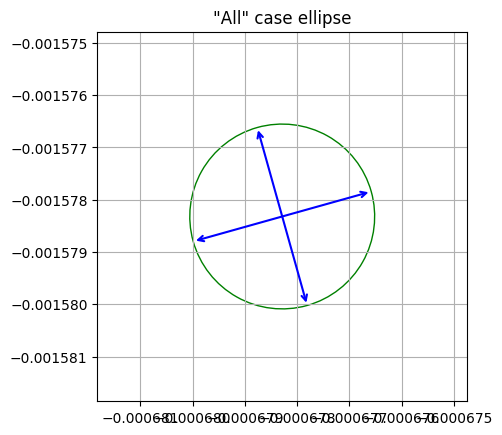

-0.0015783203736371375 -0.0015783203736371375


In [30]:
#ellipse for all data points
fig, ax = plt.subplots()

width_all, height_all = 2*np.linalg.norm(all[0]), 2*np.linalg.norm(all[1])
vec = all[0]
angle_all = np.degrees(np.arctan2(vec[0], vec[1]))
center = (As[0],Bs[0])
r = np.radians(angle_all)

ellipse_all = Ellipse(center, width_all, height_all, angle = angle_all, facecolor = 'none', edgecolor = 'green')
ax.add_patch(ellipse_all)

ax1_points = [
    (center[0] + width_all/2 * cos(r), center[1] + width_all/2 * sin(r)),
    (center[0] - width_all/2 * cos(r), center[1] - width_all/2 * sin(r))
]

ax2_points = [
    (center[0] + height_all/2 * cos(r + radians(90)), center[1] + height_all/2 * sin(r + radians(90))),
    (center[0] + height_all/2 * cos(r + radians(270)), center[1] + height_all/2 * sin(r + radians(270)))
]

arrowprops = dict(arrowstyle="<->", color="blue", linewidth=1.5)
ax.annotate("", xy=ax1_points[0], xytext=ax1_points[1], arrowprops=arrowprops)
ax.annotate("", xy=ax2_points[0], xytext=ax2_points[1], arrowprops=arrowprops)
print("Vector components of semi-minor:", all[0][0], all[0][1])
print("Vector components of semi-major:", all[1][0], all[1][1])
ax.set_xlim(center[0] - width_all, center[0] + width_all)
ax.set_ylim(center[1] - height_all, center[1] + height_all)
ax.set_aspect('equal')
ax.grid(True)

ax.set_title('"All" case ellipse')

plt.show() 
print(center[1], Bs[0])

Vector components of semi-minor: -1.3334525701073868e-06 -2.1176044025018026e-06
Vector components of semi-major: -2.115808052014563e-06 1.334584689900457e-06


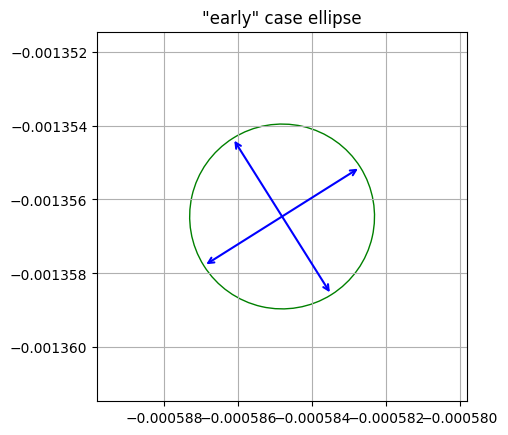

In [20]:
#ellipse for early data points
fig, ax = plt.subplots()

width_early, height_early = 2*np.linalg.norm(early[0]), 2*np.linalg.norm(early[1])
vec = early[0]
angle_early = np.degrees(np.arctan2(vec[0], vec[1]))
center = (As[1], Bs[1])
r = np.radians(angle_early)

ellipse_early = Ellipse(center, width_early, height_early, angle = angle_early, facecolor = 'none', edgecolor = 'green')
ax.add_patch(ellipse_early)

ax1_points_early = [
    (center[0] + width_early/2 * cos(r), center[1] + width_early/2 * sin(r)),
    (center[0] - width_early/2 * cos(r), center[1] - width_early/2 * sin(r))
]

ax2_points_early = [
    (center[0] + height_early/2 * cos(r + radians(90)), center[1] + height_early/2 * sin(r + radians(90))),
    (center[0] + height_early/2 * cos(r + radians(270)), center[1] + height_early/2 * sin(r + radians(270)))
]

arrowprops = dict(arrowstyle="<->", color="blue", linewidth=1.5)
ax.annotate("", xy=ax1_points_early[0], xytext=ax1_points_early[1], arrowprops=arrowprops)
ax.annotate("", xy=ax2_points_early[0], xytext=ax2_points_early[1], arrowprops=arrowprops)

ax.set_xlim(center[0] - width_early, center[0] + width_early)
ax.set_ylim(center[1] - height_early, center[1] + height_early)
ax.set_aspect('equal')
ax.set_title('"early" case ellipse')
ax.grid(True)

print("Vector components of semi-minor:", early[0][0], early[0][1])
print("Vector components of semi-major:", early[1][0], early[1][1])

plt.show() 

Vector components of semi-minor: 6.572775854283218e-07 -2.4103982321909324e-06
Vector components of semi-major: -2.4090565779894207e-06 -6.576436371193059e-07


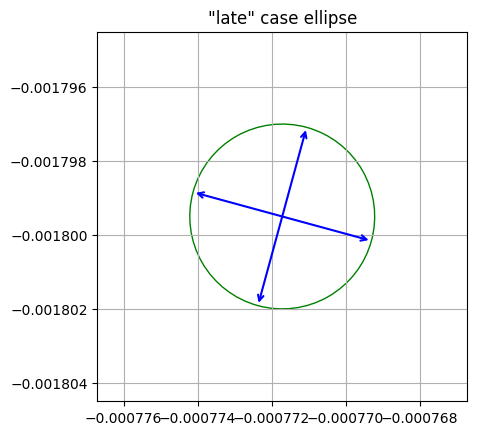

In [22]:
#ellipse for early data points
fig, ax = plt.subplots()

width_late, height_late = 2*np.linalg.norm(late[0]), 2*np.linalg.norm(late[1])
vec = late[0]
angle_late = np.degrees(np.arctan2(vec[0], vec[1]))
center = (As[2], Bs[2])
r = np.radians(angle_late)

ellipse_late = Ellipse(center, width_late, height_late, angle = angle_late, facecolor = 'none', edgecolor = 'green')
ax.add_patch(ellipse_late)

ax1_points_late = [
    (center[0] + width_late/2 * cos(r), center[1] + width_late/2 * sin(r)),
    (center[0] - width_late/2 * cos(r), center[1] - width_late/2 * sin(r))
]

ax2_points_late = [
    (center[0] + height_late/2 * cos(r + radians(90)), center[1] + height_late/2 * sin(r + radians(90))),
    (center[0] + height_late/2 * cos(r + radians(270)), center[1] + height_late/2 * sin(r + radians(270)))
]

arrowprops = dict(arrowstyle="<->", color="blue", linewidth=1.5)
ax.annotate("", xy=ax1_points_late[0], xytext=ax1_points_late[1], arrowprops=arrowprops)
ax.annotate("", xy=ax2_points_late[0], xytext=ax2_points_late[1], arrowprops=arrowprops)

ax.set_xlim(center[0] - width_late, center[0] + width_late)
ax.set_ylim(center[1] - height_late, center[1] + height_late)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title('"late" case ellipse')

print("Vector components of semi-minor:", late[0][0], late[0][1])
print("Vector components of semi-major:", late[1][0], late[1][1])
plt.show() 

In [ ]:
print(nu)

All case - semi-minor vector: [-4.76745078e-07 -1.70255119e-06]
All case - semi-major vector: [-1.70174560e-06  4.76970765e-07]
Early case - semi-minor vector: [-1.33345257e-06 -2.11760440e-06]
Early case - semi-major vector: [-2.11580805e-06  1.33458469e-06]


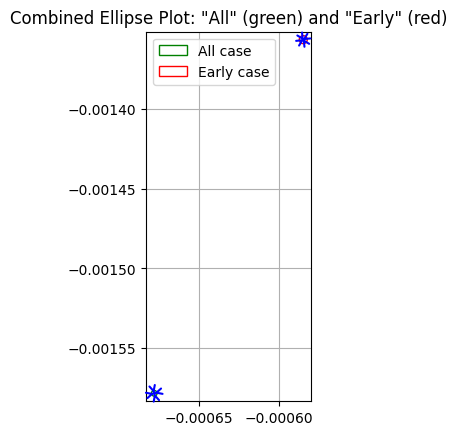

In [34]:
##combined graph

fig, ax = plt.subplots()
patches = []


#"all" case
width_all, height_all = 2*np.linalg.norm(all[0]), 2*np.linalg.norm(all[1])
vec_all = all[0]
angle_all = np.degrees(np.arctan2(vec_all[0], vec_all[1]))
center_all = (As[0], Bs[0])
r_all = np.radians(angle_all)

ellipse_all = Ellipse(center_all, width_all, height_all, angle=angle_all,
                      facecolor='none', edgecolor='green', label='All case')
ax.add_patch(ellipse_all)

ax1_points_all = [
    (center_all[0] + width_all/2 * cos(r_all), center_all[1] + width_all/2 * sin(r_all)),
    (center_all[0] - width_all/2 * cos(r_all), center_all[1] - width_all/2 * sin(r_all))
]
ax2_points_all = [
    (center_all[0] + height_all/2 * cos(r_all + radians(90)), center_all[1] + height_all/2 * sin(r_all + radians(90))),
    (center_all[0] + height_all/2 * cos(r_all + radians(270)), center_all[1] + height_all/2 * sin(r_all + radians(270)))
]

arrowprops = dict(arrowstyle="<->", color="blue", linewidth=1.5)
ax.annotate("", xy=ax1_points_all[0], xytext=ax1_points_all[1], arrowprops=arrowprops)
ax.annotate("", xy=ax2_points_all[0], xytext=ax2_points_all[1], arrowprops=arrowprops)

patches.append(ellipse_all)

#"early" case
width_early, height_early = 2*np.linalg.norm(early[0]), 2*np.linalg.norm(early[1])
vec_early = early[0]
angle_early = np.degrees(np.arctan2(vec_early[0], vec_early[1]))
center_early = (As[1], Bs[1])
r_early = np.radians(angle_early)

ellipse_early = Ellipse(center_early, width_early, height_early, angle=angle_early,
                        facecolor='none', edgecolor='red', label='Early case')
ax.add_patch(ellipse_early)

ax1_points_early = [
    (center_early[0] + width_early/2 * cos(r_early), center_early[1] + width_early/2 * sin(r_early)),
    (center_early[0] - width_early/2 * cos(r_early), center_early[1] - width_early/2 * sin(r_early))
]
ax2_points_early = [
    (center_early[0] + height_early/2 * cos(r_early + radians(90)), center_early[1] + height_early/2 * sin(r_early + radians(90))),
    (center_early[0] + height_early/2 * cos(r_early + radians(270)), center_early[1] + height_early/2 * sin(r_early + radians(270)))
]

ax.annotate("", xy=ax1_points_early[0], xytext=ax1_points_early[1], arrowprops=arrowprops)
ax.annotate("", xy=ax2_points_early[0], xytext=ax2_points_early[1], arrowprops=arrowprops)

patches.append(ellipse_early)

# ----------- Configure plot limits -----------
# Compute overall plot limits to fit both ellipses
x_vals = [center_all[0], center_early[0]]
y_vals = [center_all[1], center_early[1]]
width_max = max(width_all, width_early)
height_max = max(height_all, height_early)

ax.set_xlim(min(x_vals) - width_max, max(x_vals) + width_max)
ax.set_ylim(min(y_vals) - height_max, max(y_vals) + height_max)

ax.set_aspect('equal')
ax.grid(True)
ax.set_title('Combined Ellipse Plot: "All" (green) and "Early" (red)')
ax.legend()

# ----------- Print vectors -----------
print("All case - semi-minor vector:", all[0])
print("All case - semi-major vector:", all[1])
print("Early case - semi-minor vector:", early[0])
print("Early case - semi-major vector:", early[1])

plt.show()

In [ ]:
#combined graph trial

